# Parse saved HTML files

The purpose of this notebook is to scrape data from the saved html files created by the scaper.  

[Github Repo](https://github.com/DSE-capstone-sharknado/scraper/blob/master/README.md)

## Todo
* Merge the scraping logic in this notebook with the scraper if future scraping is needed


## Clean Up

cleaning up what the scraper failed to parse and generate hdf file as output


In [1]:
import pandas as pd
%pylab inline
from IPython.core.display import HTML
from lxml import html
import json
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pwd

u'/Users/juliusremigio/Documents/DSE/Capstone/scraper'

In [3]:

def extract(asin):
    # this function parses values missed by the parser logic in the scraper
    def getProductInfo(raw):
        # parse tabular list and return dictionary
        rows = [x for x in raw if str(type(x)) == "<class 'lxml.html.HtmlElement'>"]

        mydic = dict()
        mylist = [x for x in rows if x.tag == 'li']

        for li in mylist:
            if len(li.getchildren()) == 1:
                mydic[li[0].text.strip()] = li[0].tail.strip() if li[0].tail is not None else ''
            else:
                mydic[li[0].text.strip()] = li[0].tail.strip() + ''.join([x.text_content().strip() + (x.tail.strip() if x.tail is not None else '') for x in li[1:] if x.tag not in ['ul','style','script']])

        return mydic
    source =  u''.join([x.decode('utf-8') for x in open('./html/{asin}.html'.format(asin=asin), 'rb')])
    doc = html.fromstring(source)

    XPATH_BRAND_img = '//a[@id="brand"]/@href'
    XPATH_PRODUCT_INFO_li = '//div[@id="detailBullets_feature_div"]//li//text()'
    XPATH_PRODUCT_INFO_div2 = '//div[@id="detail-bullets"]//div[@class="content"]/ul/node()'
    XPATH_PRODUCT_DESC2 = '//div[@id="productDescription"]//text()'
    
    RAW_BRAND_img = doc.xpath(XPATH_BRAND_img)
    RAW_PRODUCT_INFO_li = doc.xpath(XPATH_PRODUCT_INFO_li)
    RAW_PRODUCT_INFO_div2 = doc.xpath(XPATH_PRODUCT_INFO_div2)
    RAW_PRODUCT_DESC2 = doc.xpath(XPATH_PRODUCT_DESC2)
    
    BRAND_img = None
    if len(RAW_BRAND_img) > 0:
        BRAND_img = ' '.join(RAW_BRAND_img[0].split('=')[-1].split('+'))
    
    PRODUCT_INFO_li = [x.strip() for x in RAW_PRODUCT_INFO_li if x is not None and x.strip() != '']
    PRODUCT_INFO_div2 = getProductInfo(RAW_PRODUCT_INFO_div2)
    PRODUCT_DESC2 = ' '.join([x.strip() for x in RAW_PRODUCT_DESC2 if x.strip() != ''])
    
    return {
            'BRAND' : BRAND_img,
            'PRODUCT_INFO' : dict(zip(PRODUCT_INFO_li[::2],PRODUCT_INFO_li[1::2])) if len(PRODUCT_INFO_li) > 0 else PRODUCT_INFO_div2,
            'PRODUCT_DESC' : PRODUCT_DESC2
           }

with open('reviews_Women.jl', 'rb') as f:
    i = 0
    try:
        for l in f:
            i += 1
            json.loads(l)
    except Exception as e:
        print i, e

In [4]:
df = pd.read_json('reviews_Women.jl', lines=True)

# exclude duplicate entries by asin
df = df.groupby('asin').head(1)

In [5]:
df.head()

,BRAND,FEATURE_BULLETS,NAME,ORIGINAL_PRICE,PRODUCT_DESCRIPTION,PRODUCT_INFORMATION,SALE_PRICE,URL,asin
0,Suunto,"[Imported, Watch, altimeter, barometer, and co...",Suunto Vector Wrist-Top Computer Watch with Al...,None,All the data you need in the outdoors is just ...,{},None,https://amazon.com/dp/,B000051SEN
1,AmeriBag,"[Nylon, Easy-see silver nylon lining, Double-z...","AmeriBag Distressed Nylon Bag, Taupe, Extra Small",$50.99,Enhance your active lifestyle with the AmeriBa...,{},$50.99,https://amazon.com/dp/,B000078CYM
2,Palm Beach Jewelry,[Top Rated Seller - Trusted Since 1952 - 90 Da...,PalmBeach Jewelry Open Weave Decorative Band i...,None,The delicate beauty of this open-weave band re...,{},None,https://amazon.com/dp/,B00007FFL9
3,Buxton,"[Leatherette, Imported, Flap closure, 25"" shou...",Buxton Crossbody Mini Cross Body Bag,$23.68,"Going out on the town, concert or to a basebal...",{},$23.68,https://amazon.com/dp/,B00007GD8X
4,Buxton,"[Leather, Importado, flap closure, Brush with ...",Buxton Heiress Convertible Billfold Wallet,$15.74,"Authentic crunch leather, rich floral emboss h...",{},$15.74,https://amazon.com/dp/,B00007GD9W


In [7]:
print df.columns
print df.shape

Index([u'BRAND', u'FEATURE_BULLETS', u'NAME', u'ORIGINAL_PRICE',
       u'PRODUCT_DESCRIPTION', u'PRODUCT_INFORMATION', u'SALE_PRICE', u'URL',
       u'asin'],
      dtype='object')
(12943, 9)


In [6]:
# check for captcha
captcha = [x.replace('.html', '') for x in os.listdir('./html') if x.endswith('.html') and os.stat('./html/'+ x).st_size ==6467]

len(captcha)

0

## Analyze Brand

In [8]:
df.BRAND.describe()

count     12943
unique     1635
top            
freq       5125
Name: BRAND, dtype: object

In [9]:
# check for null or empty strings
df[(df.BRAND.isnull()) | (df.BRAND == '')].groupby('BRAND')['BRAND'].count()

BRAND
    5125
Name: BRAND, dtype: int64

In [10]:
m_brand = df[(df.BRAND.isnull()) | (df.BRAND == '')]
# fix only missing brands
df.ix[m_brand.index,['BRAND']] = m_brand.apply(lambda x: extract(x['asin'])['BRAND'], axis=1)

In [11]:
df[(df.BRAND.isnull()) | (df.BRAND == '')].shape

(116, 9)

## Analyze Product Information

In [12]:
#count empty dictionaries
m_pi = df[df.PRODUCT_INFORMATION==dict()]
m_pi.shape

(12863, 9)

In [13]:
m_pi[['asin','PRODUCT_INFORMATION']].head()

,asin,PRODUCT_INFORMATION
0,B000051SEN,{}
1,B000078CYM,{}
2,B00007FFL9,{}
3,B00007GD8X,{}
4,B00007GD9W,{}


In [14]:
df.ix[m_pi.index,['PRODUCT_INFORMATION']] = m_pi.apply(lambda x: extract(x['asin'])['PRODUCT_INFO'], axis=1)

In [15]:
df[df.PRODUCT_INFORMATION==dict()].shape

(14, 9)

In [20]:
df[df.PRODUCT_INFORMATION==dict()].head()

,BRAND,FEATURE_BULLETS,NAME,ORIGINAL_PRICE,PRODUCT_DESCRIPTION,PRODUCT_INFORMATION,SALE_PRICE,URL,asin
1894,Alexander Del Rossa,"[Durable, water absorbant bathrobe for everyda...","Del Rossa Women's Fleece Robe, Plush Microfibe...",$39.99 - $44.98,,{},$39.99 - $44.98,https://amazon.com/dp/,B002YSYV9W
3532,Alexander Del Rossa,[Soft 100% cotton flannel pajamas for everyday...,"Del Rossa Women's Flannel Pajamas, Long Cotton...",$27.99 - $31.98,,{},$27.99 - $31.98,https://amazon.com/dp/,B004I49NEI
4355,Alexander Del Rossa,[Soft 100% cotton woven pajamas for everyday u...,"Del Rossa Women's Cotton Pajamas, Woven Pj Set...",$24.99 - $39.98,,{},$24.99 - $39.98,https://amazon.com/dp/,B00563KB5K
4724,Kooljewelry,[Classic box chain makes a simple basic casual...,"Sterling Silver 0.9mm Venetian Box Chain (14, ...",$10.49,,{},$10.49,https://amazon.com/dp/,B0051TZSMK
4737,Kooljewelry,[Classic open link chain makes a simple basic ...,"Sterling Silver 1.5mm Open Link Chain (14, 16,...",$7.49,,{},$7.49,https://amazon.com/dp/,B0052DA68G


## Analyze Product Description

In [16]:
m_pd = df[(df.PRODUCT_DESCRIPTION == '') | df.PRODUCT_DESCRIPTION.isnull()]
m_pd.shape

(1776, 9)

In [17]:
m_pd[['asin','PRODUCT_DESCRIPTION']].head()

,asin,PRODUCT_DESCRIPTION
18,B0000869QI,
23,B00008ECKG,
37,B0000AZ10F,
49,B0000B35GE,
64,B0000TIIPA,


In [18]:
df.ix[m_pd.index,['PRODUCT_DESCRIPTION']] = m_pd.apply(lambda x: extract(x['asin'])['PRODUCT_DESC'], axis=1)

In [19]:
df[(df.PRODUCT_DESCRIPTION == '') | df.PRODUCT_DESCRIPTION.isnull()].shape

(1391, 9)

In [21]:
df[(df.PRODUCT_DESCRIPTION == '') | df.PRODUCT_DESCRIPTION.isnull()].tail()

,BRAND,FEATURE_BULLETS,NAME,ORIGINAL_PRICE,PRODUCT_DESCRIPTION,PRODUCT_INFORMATION,SALE_PRICE,URL,asin
12875,LEE,"[94% Cotton/6% Spandex, Machine Wash, Shapetas...",Lee Women's Perfect Fit Nancy Barely Bootcut P...,None,,"{u'ASIN:': u'B007JF11Z2', u'Product Dimensions...",None,https://amazon.com/dp/,B007JF0UEK
12896,Felina,[Fabric Content: 83% Nylon/17% Spandex; Mesh: ...,Felina Women's Harlow Unlined Demi Bra,$9.95 - $49.00 Lower price available on select...,,"{u'Product Dimensions:': u'1 x 1 x 1 inches', ...",$9.95 - $49.00 Lower price available on select...,https://amazon.com/dp/,B00008ECKG
12913,FUNOC,[Imported],Fashion Womens Ladies High Waist Plain Pleated...,None,,"{u'ASIN:': u'B00GJG91RM', u'Product Dimensions...",None,https://amazon.com/dp/,B00GJG91RM
12920,Vanity Fair,"[100% Nylon, Machine Wash, Half slip featuring...",Vanity Fair Women's Plus Size Tricot Double Sl...,$9.99 - $17.00 Lower price available on select...,,"{u'ASIN:': u'B071YRRBFX', u'Item model number:...",$9.99 - $17.00 Lower price available on select...,https://amazon.com/dp/,B0006I7IA6
12935,None,[],"niceEshop(TM) Fashion Vintage Gold,plated Allo...",None,,"{u'ASIN:': u'B00DM05FV4', u'Product Dimensions...",None,https://amazon.com/dp/,B00DM05FV4


In [22]:
# save dataframe to file

df.to_hdf('scraped.hd5', key='womens', complib='blosc', complevel=9, mode='w')

/Users/juliusremigio/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
/Users/juliusremigio/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->[u'BRAND', u'FEATURE_BULLETS', u'NAME', u'ORIGINAL_PRICE', u'PRODUCT_DESCRIPTION', u'PRODUCT_INFORMATION', u'SALE_PRICE', u'URL', u'asin']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
/Users/juliusremigio/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

In [ ]:
def View(html):
    # this function injects html into the output cell to display html inline
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "html document", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + html + '\';'
    s += '</script>'

    return(HTML(s))


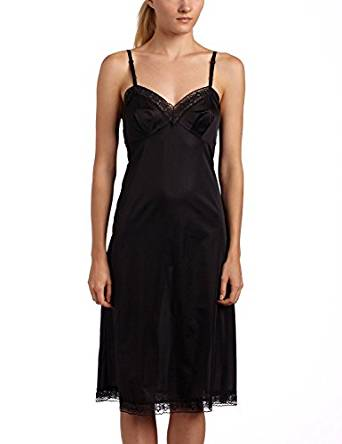

In [240]:
# source = u''.join([x.decode('utf-8') for x in open('./html/B0000862FI.html', 'rb')])
# View(source)